# Monte Carlo Analysis on an Infinite Shoe

In [2]:
import itertools
import numpy as np
import sys
sys.path.append("..")

from collections import defaultdict
from matplotlib import pyplot as plt

from common.hand import Hand
from common.card import Card
from common.enums import PlayerAction, GameState
from engine.blackjack import Blackjack

from helpers.printer import print_best_actions

Let us use the Monte Carlo method to determine the best move a player can make, given some hand that the the player has against the up facing card a dealer is showing.

By averaging the rewards of all simulations for a given scenario \[hand, dealers_hand\] and action, we can statistically deduce the optimal action for each starting scenario.

Since many hands when HIT still require an additional action (such as a HIT on 13 and receiving a 2, resulting in a 15), we can reduce computational time by reusing the average reward calcuated from the new scenario (in the case of the previous example where the original scenario is \[hand=13, dealers_hand\] and a HIT of 2, the reward we will return for that run of the simulation is the previously averaged reward of the new scenario \[hand=15, dealers_hand\]).

Let's set up all the possible scenarios of hands, dealer_hands, and actions.

We want to order the scenarios so that the results of a given scenario can be reused to assist in determining the average rewards of subsequent hands.

In [4]:
hands = np.array([
    Hand([Card.TEN, Card.TEN, Card.ACE], wager=1),        # 21
    Hand([Card.TEN, Card.FIVE, Card.FIVE], wager=1),      # 20
    Hand([Card.TEN, Card.NINE], wager=1),                 # 19
    Hand([Card.TEN, Card.EIGHT], wager=1),                # 18
    Hand([Card.TEN, Card.SEVEN], wager=1),                # 17
    Hand([Card.TEN, Card.SIX], wager=1),                  # 16
    Hand([Card.TEN, Card.FIVE], wager=1),                 # 15
    Hand([Card.TEN, Card.FOUR], wager=1),                 # 14
    Hand([Card.TEN, Card.THREE], wager=1),                # 13
    Hand([Card.TEN, Card.TWO], wager=1),                  # 12
    Hand([Card.NINE, Card.TWO], wager=1),                 # 11
    Hand([Card.ACE, Card.TEN], wager=1),                  # Soft 21
    Hand([Card.EIGHT, Card.TWO], wager=1),                # 10
    Hand([Card.ACE, Card.NINE], wager=1),                 # Soft 20
    Hand([Card.SEVEN, Card.TWO], wager=1),                # 9
    Hand([Card.ACE, Card.EIGHT], wager=1),                # Soft 19
    Hand([Card.SIX, Card.TWO], wager=1),                  # 8
    Hand([Card.ACE, Card.SEVEN], wager=1),                # Soft 18
    Hand([Card.FIVE, Card.TWO], wager=1),                 # 7
    Hand([Card.ACE, Card.SIX], wager=1),                  # Soft 17
    Hand([Card.FOUR, Card.TWO], wager=1),                 # 6
    Hand([Card.ACE, Card.FIVE], wager=1),                 # Soft 16
    Hand([Card.THREE, Card.TWO], wager=1),                # 5
    Hand([Card.ACE, Card.FOUR], wager=1),                 # Soft 15
    Hand([Card.ACE, Card.THREE], wager=1),                # Soft 14
    Hand([Card.ACE, Card.TWO], wager=1),                  # Soft 13
    Hand([Card.ACE, Card.ACE], wager=1),                  # Soft 12
    Hand([Card.TEN, Card.TEN], wager=1),                  # Pair 10
    Hand([Card.NINE, Card.NINE], wager=1),                # Pair 9
    Hand([Card.EIGHT, Card.EIGHT], wager=1),              # Pair 8
    Hand([Card.SEVEN, Card.SEVEN], wager=1),              # Pair 7
    Hand([Card.SIX, Card.SIX], wager=1),                  # Pair 6
    Hand([Card.FIVE, Card.FIVE], wager=1),                # Pair 5
    Hand([Card.FOUR, Card.FOUR], wager=1),                # Pair 4
    Hand([Card.THREE, Card.THREE], wager=1),              # Pair 3
    Hand([Card.TWO, Card.TWO], wager=1)                   # Pair 2
])

dealers_hands = np.array([
    Hand([Card.ACE]),
    Hand([Card.TEN]),
    Hand([Card.NINE]),
    Hand([Card.EIGHT]),
    Hand([Card.SEVEN]),
    Hand([Card.SIX]),
    Hand([Card.FIVE]),
    Hand([Card.FOUR]),
    Hand([Card.THREE]),
    Hand([Card.TWO])
])

actions = np.array([
    PlayerAction.STAY,
    PlayerAction.HIT,
    PlayerAction.DOUBLE,
    PlayerAction.SPLIT
])

We will also create a few helpers to convert a hand/dealer_hand/action to a numerical representation for easier indexing.

In [186]:
hand_to_idx_map = dict((h, i) for (i, h) in enumerate(hands))
dealers_hand_to_idx_map = dict((dh, i) for (i, dh) in enumerate(dealers_hands))
actions_to_idx_map = dict((a, i) for (i, a) in enumerate(actions))

To calculate the average "reward" for a given scenario (i.e. \[hand, dealer_hand\]) and action, we run a simulation x number of times (default 1000) and keep a running average of the reward returned by each simulation.

A few outcomes can occur from a single action.

1) STAY results in dealer bust -> reward is 1  
2) STAY results in a push -> reward is 0  
3) STAY results in a win -> reward is 1  
4) STAY results in a loss -> reward is -1  
5) DOUBLE results in a bust -> reward is -2  
6) DOUBLE in some hand under 22 -> reward is 2 times the average reward for STAYing on the new hand  
7) HIT results in a bust -> reward is -1  
8) HIT results in some hand under 22 -> reward is the best average reward between HITing and STAYing on the new hand  
9) SPLIT creates two new hands -> reward is the sum of the best reward from any action on the two new hands  

As can be seen, some of the possibilities require pre-calculated averages. Thus it is important which order the rewards are calcuated in.

First we should calculate the results of all the STAY actions. The reasoning is simple, the rewards for these actions do not depend on any pre-calcuated values.

The next simplest averages to calculate are those of the DOUBLE action. Either the player busts, or we use the averages from the STAY actions to determine the reward.

For HIT, we will need to make sure that we calculate this backwards from highest possible hand to lowest. The reason for this is that a HIT on a small hand may result in a larger hand, here we would like to know the average reward for the best next action, whether this be to STAY or to HIT. But we would not know which action to choose (nor its average reward) if it is not calculated first. The highest possible hand, 21 has no dependencies as any HIT on a 21 will result in a bust (loss). Every hand lower than 21 then is only dependent on the averages calculated for the hands larger than itself.

Finally, the last action we will need to calculate average rewards for is SPLIT. This one is a bit more difficult. When a split occurs, we have two new hands. Each of these hands by this point will already have the average reward for HIT, STAY, and DOUBLE pre-calculated. However, there is a possibility that a split results in a hand with another pair. Since we are in the process of calculating that exact pair, we end up in a chicken or the egg situation.

In [338]:
def running_avg(avg, n, val):
    return (1 - 1.0 / n) * avg + 1.0 / n * val

def perform_action(hand, dealers_hand, action, returns_cache):
    if not hand.can_perform_action(action): raise ValueError('Unexpected action=' + action)
        
    game = Blackjack(dealers_hand=dealers_hand, hands=[hand]) # plural hands because a split would produce 2 hands
    
    game.perform_action(PlayerAction.BET, wager=1)
    game_state, new_hands, 
    

def run_simulation(hand, dealers_hand, action, returns_cache, iters=1000):
    if not hand.can_perform_action(action): return
    
    hand_idx = hand_to_idx_map[hand]
    dealers_hand_idx = dealers_hand_to_idx_map[dealers_hand]
    action_idx = actions_to_idx_map[action]
    stay_idx = actions_to_idx_map[PlayerAction.STAY]
    
    returns_cache[hand_idx][dealers_hand_idx][action_idx] = 0
    
    extra_wager = hand.wager if action in [PlayerAction.DOUBLE, PlayerAction.SPLIT] else None
    total_wager = hand.wager + (extra_wager or 0)
    
    for i in range(iters):
        game = Blackjack(state=GameState.PLAYING, 
                                 dealers_hand=dealers_hand, 
                                 hands=[hand], 
                                 hand=0)
        
        game_state, new_hands, _, _, reward = game.perform_action(action, wager=extra_wager)
        
        if game_state == GameState.FINISHED:
            avg_return = returns_cache[hand_idx][dealers_hand_idx][action_idx]
            new_avg_return = running_avg(avg_return, i + 1, reward - total_wager)
            returns_cache[hand_idx][dealers_hand_idx][action_idx] = new_avg_return
        elif (game_state == GameState.PLAYING):
            new_hands_indices = list(map(lambda hand: hand_to_idx_map[hand], new_hands))
            if hand.cards[0] == Card.ACE and action == PlayerAction.SPLIT:
                reward = returns_cache[new_hands_indices[0]][dealers_hand_idx][stay_idx]
                reward += returns_cache[new_hands_indices[1]][dealers_hand_idx][stay_idx]
            elif action == PlayerAction.SPLIT:
                reward = np.max(returns_cache[new_hands_indices[0]][dealers_hand_idx])
                reward += np.max(returns_cache[new_hands_indices[1]][dealers_hand_idx])
            else:
                reward = np.max(returns_cache[new_hands_indices[0]][dealers_hand_idx])
                
            avg_return = returns_cache[hand_idx][dealers_hand_idx][action_idx]
            new_avg_return = running_avg(avg_return, i + 1, reward)
            returns_cache[hand_idx][dealers_hand_idx][action_idx] = new_avg_return
        else:
            raise ValueError('Unexpected GameState ' + game_state)

In [339]:
iters=1000
returns_cache = np.full((len(hands), len(dealers_hands), len(actions)), -np.inf)

for hand in hands:
    for dealers_hand in dealers_hands:
        for action in actions:
            run_simulation(hand, dealers_hand, action, returns_cache, iters)

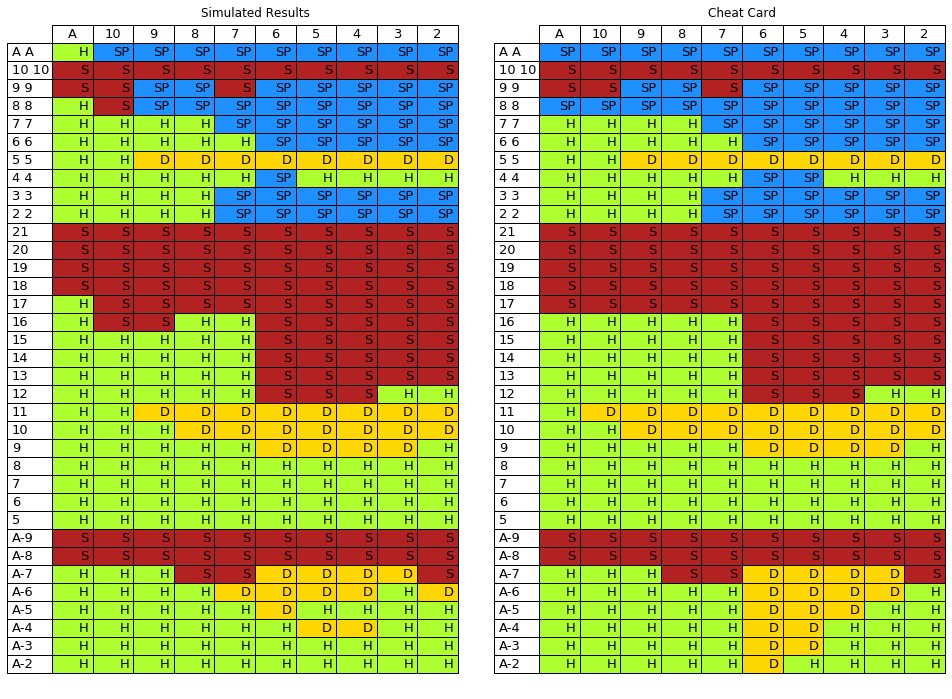

In [340]:
# Create row and column labels as well as definitions for actions and corresponding cell colours
hand_labels = np.array(['A A', '10 10', '9 9', '8 8', '7 7', '6 6', '5 5', '4 4', \
                        '3 3', '2 2', '21', '20', '19', '18', '17', '16', '15', \
                        '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', \
                        'A-9', 'A-8', 'A-7', 'A-6', 'A-5', 'A-4', 'A-3', 'A-2'])
dealers_hand_labels = np.array(['A', '10', '9', '8', '7', '6', '5', '4', '3', '2'])
action_labels = np.array(['S', 'H', 'D', 'SP'])
action_colours = np.array(['firebrick', 'greenyellow', 'gold', 'dodgerblue'])

# These are the indices of the hands that we are interested in charting
returns_cache_indices = [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 0, 1, 2, 3, 4, 5, 6, 7, 8, \
                         9, 10, 12, 14, 16, 18, 20, 22, 13, 15, 17, 19, 21, 23, 24, 25]
returns = returns_cache[returns_cache_indices][:][:]
best_action_indices = np.argmax(returns, axis=2)

# These are the best actions according to https://wizardofodds.com/games/blackjack/appendix/1/
standard_best_action_indices = [
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 3, 0, 3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [1, 1, 1, 1, 3, 3, 3, 3, 3, 3],
    [1, 1, 1, 1, 1, 3, 3, 3, 3, 3],
    [1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
    [1, 1, 1, 1, 1, 3, 3, 1, 1, 1],
    [1, 1, 1, 1, 3, 3, 3, 3, 3, 3],
    [1, 1, 1, 1, 3, 3, 3, 3, 3, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
    [1, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    [1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 2, 2, 2, 2, 0],
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 1],
    [1, 1, 1, 1, 1, 2, 2, 2, 1, 1],
    [1, 1, 1, 1, 1, 2, 2, 1, 1, 1],
    [1, 1, 1, 1, 1, 2, 2, 1, 1, 1],
    [1, 1, 1, 1, 1, 2, 1, 1, 1, 1]
]

best_actions = action_labels[best_action_indices]
best_cell_colours = action_colours[best_action_indices]

standard_best_actions = action_labels[standard_best_action_indices]
standard_best_cell_colours = action_colours[standard_best_action_indices]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
    
ax1.axis('tight')
ax1.axis('off')
ax1.set_title('Simulated Results')
tbl1= ax1.table(cellText=best_actions, 
                rowLabels=hand_labels,
                colLabels=dealers_hand_labels,
                cellColours=best_cell_colours,
                loc='center')
tbl1.set_fontsize(13)
tbl1.scale(1, 1.5)

ax2.set_title('Cheat Card')
ax2.axis('tight')
ax2.axis('off')
tbl2 = ax2.table(cellText=standard_best_actions,
                 rowLabels=hand_labels,
                 colLabels=dealers_hand_labels,
                 cellColours=standard_best_cell_colours,
                 loc='center')
tbl2.set_fontsize(13)
tbl2.scale(1, 1.5)

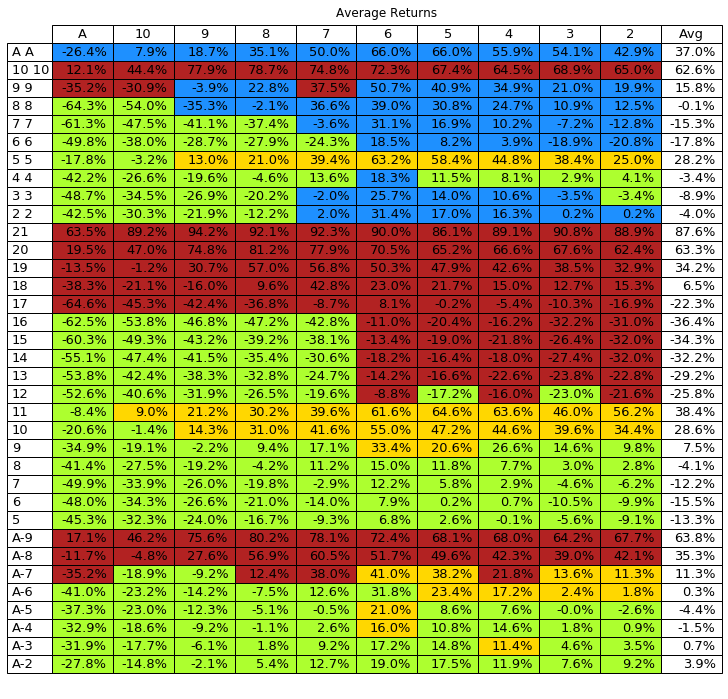

In [344]:
best_rewards = np.max(returns, axis=2)
avg_rewards = np.mean(best_rewards, axis=1, keepdims=True)
total_avg_rewards = np.mean(avg_rewards)

format_to_percentage = np.vectorize(lambda x: '{:.1f}%'.format(x * 100))
rewards = format_to_percentage(np.append(best_rewards, avg_rewards, axis=1))
col_labels = np.append(dealers_hand_labels, ['Avg'])
avg_cell_colours = np.tile('white', (hand_labels.shape[0], 1))
cell_colours = np.append(action_colours[best_chart_actions], avg_cell_colours, axis=1)

fig, ax = plt.subplots(figsize=(8, 12))
ax.axis('tight')
ax.axis('off')
ax.set_title('Average Returns')
table = ax.table(cellText=rewards,
                 rowLabels=hand_labels,
                 colLabels=col_labels,
                 cellColours=cell_colours,
                 loc='center')

table.set_fontsize(13)
table.scale(1.5, 1.5)

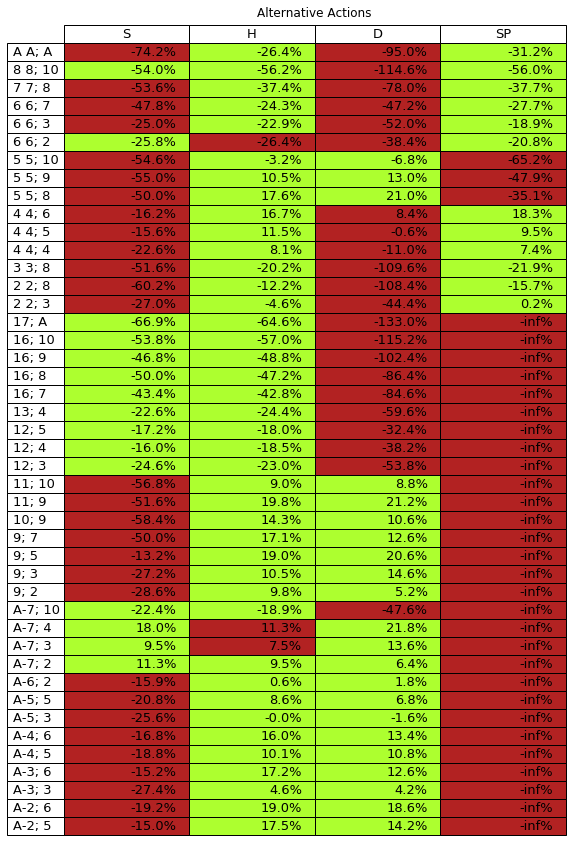

In [374]:
valid_actions = 1 * (np.subtract(best_rewards[:,:,None], returns) < 0.05)
special_cases = np.transpose(np.where(np.sum(valid_actions, axis=2) > 1))
special_returns = format_to_percentage(returns[special_cases[:,0], special_cases[:,1]])
special_hand_labels = np.core.defchararray.add(np.core.defchararray.add(hand_labels[special_cases[:,0]], '; '), dealers_hand_labels[special_cases[:,1]])
special_action_colours = np.array(['firebrick', 'greenyellow'])
special_cell_colours = special_action_colours[valid_actions[special_cases[:,0], special_cases[:,1]]]

fig, ax = plt.subplots(figsize=(6, 15))
ax.axis('tight')
ax.axis('off')
ax.set_title('Alternative Actions')
table = ax.table(cellText=special_returns,
                 rowLabels=special_hand_labels,
                 colLabels=action_labels,
                 cellColours=special_cell_colours,
                 loc='center')

table.set_fontsize(13)
table.scale(1.5, 1.5)